In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
import re 
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve,classification_report,roc_auc_score
import warnings
import collections
import itertools
import pickle
from sklearn.naive_bayes import MultinomialNB

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("flipkart.csv")

In [4]:
df.head()

,Unnamed: 0,CommentHead,Comment,Rating
0,0,Classy product,Very nice product,5.0
1,1,Good choice,Too good,4.0
2,2,Fabulous!,Good products,5.0
3,3,Hated it!,Very bad products,1.0
4,4,Super!,Sorry,5.0


In [5]:
df.columns

Index(['Unnamed: 0', 'CommentHead', 'Comment', 'Rating'], dtype='object')

In [6]:
df.drop(columns=["Unnamed: 0"],inplace=True)

In [7]:
df.head()

,CommentHead,Comment,Rating
0,Classy product,Very nice product,5.0
1,Good choice,Too good,4.0
2,Fabulous!,Good products,5.0
3,Hated it!,Very bad products,1.0
4,Super!,Sorry,5.0


In [8]:
df.columns

Index(['CommentHead', 'Comment', 'Rating'], dtype='object')

In [9]:
df.dtypes

CommentHead     object
Comment         object
Rating         float64
dtype: object

In [10]:
df["Rating"].unique()

array([ 5.,  4.,  1.,  2.,  3., nan])

In [11]:
df.isna().sum()

CommentHead    0
Comment        0
Rating         1
dtype: int64

In [12]:
df["Rating"]=df["Rating"].fillna(4)

In [13]:
df.isna().sum()

CommentHead    0
Comment        0
Rating         0
dtype: int64

In [14]:
df["Rating"]=df["Rating"].astype(int)

In [15]:
df.head()

,CommentHead,Comment,Rating
0,Classy product,Very nice product,5
1,Good choice,Too good,4
2,Fabulous!,Good products,5
3,Hated it!,Very bad products,1
4,Super!,Sorry,5


In [16]:
df.describe()

,Rating
count,12130.000000
mean,3.170486
std,1.668342
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,5.000000


In [17]:
df['length']=df['Comment'].apply(len)

In [18]:
df.head()

,CommentHead,Comment,Rating,length
0,Classy product,Very nice product,5,17
1,Good choice,Too good,4,8
2,Fabulous!,Good products,5,13
3,Hated it!,Very bad products,1,17
4,Super!,Sorry,5,5


In [19]:
df.groupby('length').describe().sample(5)

Rating                                               
        count      mean       std  min   25%  50%   75%  max
length                                                      
139       4.0  3.500000  1.732051  1.0  3.25  4.0  4.25  5.0
333       1.0  4.000000       NaN  4.0  4.00  4.0  4.00  4.0
267       1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0
109      17.0  3.235294  1.714986  1.0  1.00  4.0  5.00  5.0
277       2.0  4.000000  1.414214  3.0  3.50  4.0  4.50  5.0

In [20]:
df.groupby('Rating').describe()

length                                                    
         count       mean        std  min   25%   50%   75%    max
Rating                                                            
1       3541.0  42.836487  49.203929  2.0  15.0  26.0  51.0  500.0
2       1128.0  37.644504  42.852613  2.0  13.0  24.0  45.0  460.0
3       1454.0  39.961486  56.170127  2.0  12.0  23.0  45.0  500.0
4       1736.0  42.863479  64.055652  1.0  12.0  21.0  44.0  500.0
5       4271.0  38.398502  55.116317  2.0  11.0  19.0  39.0  500.0

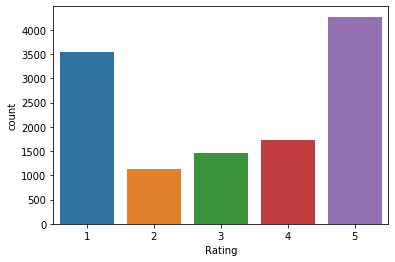

In [21]:
sns.countplot(df["Rating"])

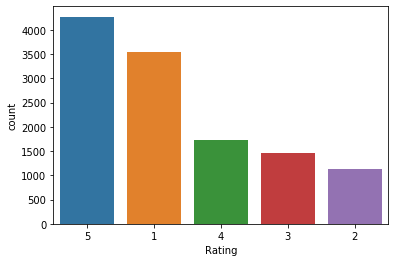

In [22]:
sns.countplot(df["Rating"],order=df["Rating"].value_counts().index)

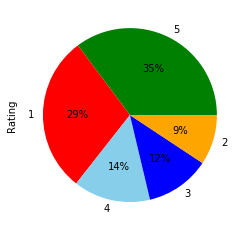

In [23]:
df["Rating"].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=["green", "red", "skyblue","blue","orange"])

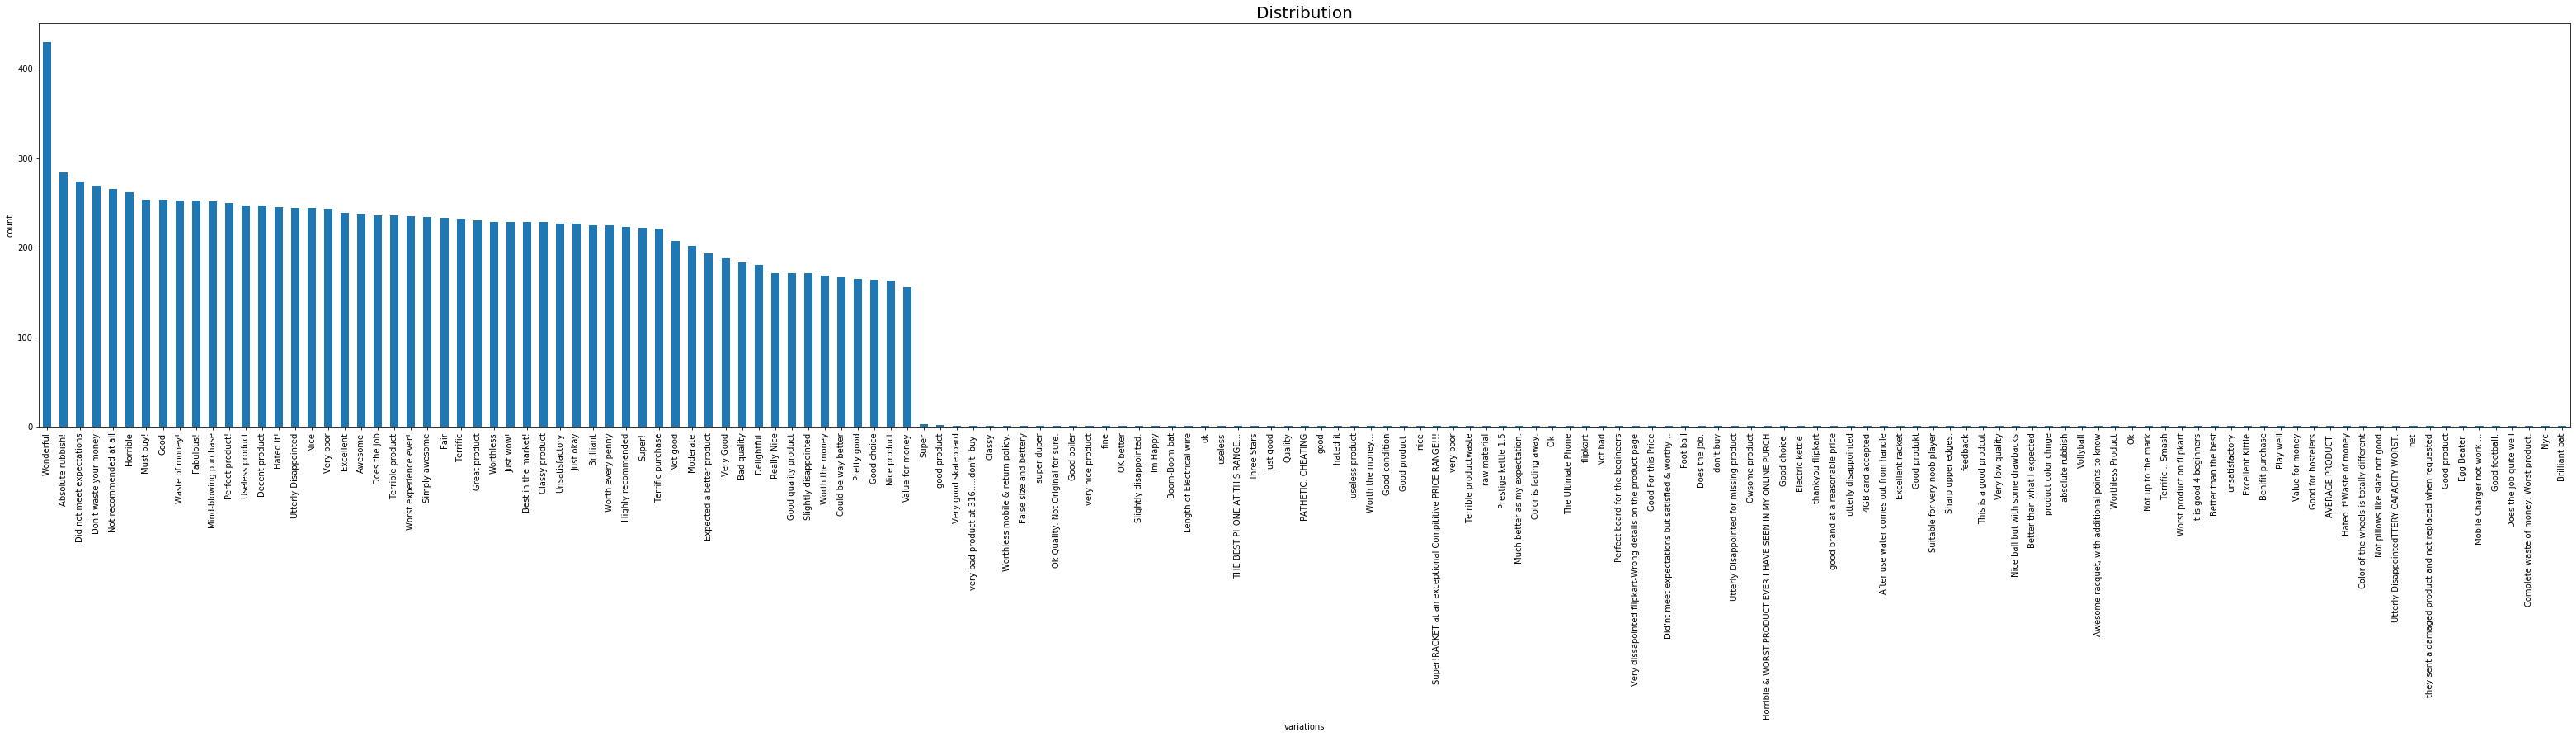

In [24]:
df['CommentHead'].value_counts().plot.bar(figsize=(55, 9))
plt.title('Distribution',fontsize = 20)
plt.xlabel('variations')
plt.ylabel('count')
plt.show()

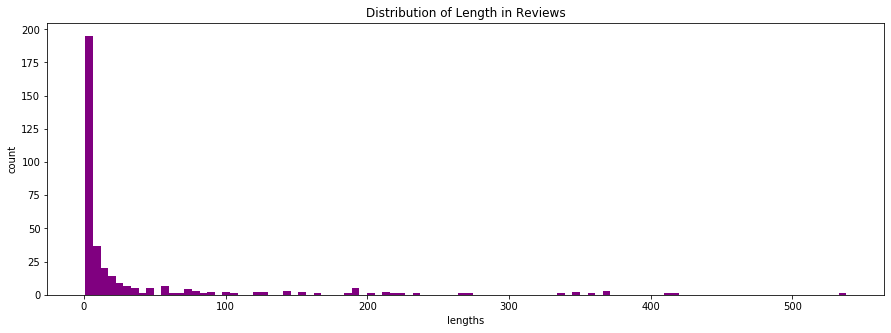

In [25]:
df['length'].value_counts().plot.hist(figsize=(15,5),bins=100,color="purple")
plt.title('Distribution of Length in Reviews')
plt.xlabel('lengths')
plt.ylabel('count')
plt.show()

In [26]:
df[df['length']==2]['Comment'].iloc[0]

'Ok'

In [27]:
df[df['length']==3]['Comment'].iloc[0]

'Bad'

In [28]:
df[df['length']==29]['Comment'].iloc[0]

'This one is very good produce'

In [22]:
def rating(cols):
    rating=cols[0]
    if(rating>3):
        return +1
    elif(rating<3):
        return -1
    else:
        return 0

In [23]:
df['sentiment']=df[['Rating']].apply(rating,axis=1)

In [24]:
df.head()

,CommentHead,Comment,Rating,length,sentiment
0,Classy product,Very nice product,5,17,1
1,Good choice,Too good,4,8,1
2,Fabulous!,Good products,5,13,1
3,Hated it!,Very bad products,1,17,-1
4,Super!,Sorry,5,5,1


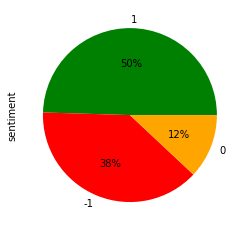

In [32]:
df["sentiment"].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=["green","red","orange"])

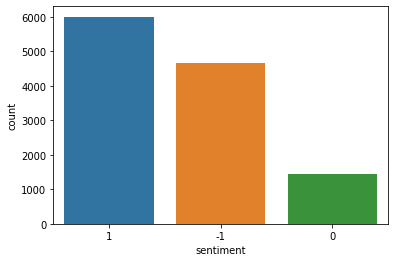

In [33]:
sns.countplot(df["sentiment"],order=df["sentiment"].value_counts().index)

In [25]:
text=df['Comment'].to_numpy()

In [26]:
stop_words=set(stopwords.words('english'))

In [27]:
ps=PorterStemmer()

In [28]:
detokenizer=TreebankWordDetokenizer()

In [29]:
resText=[]

In [30]:
try:
    for i,j in enumerate(text):
        sentences=sent_tokenize(j)
        for sentence in sentences:
            sentence=sentence.lower()
            words=word_tokenize(sentence)
            stopped_words=[k for k in words if not k in stop_words]
            stem_words=[ps.stem(word) for word in stopped_words]
            new_sentence=detokenizer.detokenize(stem_words)
        resText.append(new_sentence)
except Exception as e: 
    print(e)

In [31]:
features=[]
for i in range(len(resText)):
    #remove all special characters
    feature=re.sub(r'\W',' ',str(resText[i]))
    #remove all single characters
    feature=re.sub(r'\s+[a-zA-Z]\s+',' ',feature)
    # Substituting multiple spaces with single space
    feature=re.sub(r'\s+',' ',feature,flags=re.I)
    features.append(feature)

In [32]:
df["features"]=features

In [33]:
df.head()

,CommentHead,Comment,Rating,length,sentiment,features
0,Classy product,Very nice product,5,17,1,nice product
1,Good choice,Too good,4,8,1,good
2,Fabulous!,Good products,5,13,1,good product
3,Hated it!,Very bad products,1,17,-1,bad product
4,Super!,Sorry,5,5,1,sorri


In [34]:
labels=df.iloc[:,4].values

In [35]:
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [36]:
df["sentiment"].unique()

array([ 1, -1,  0], dtype=int64)

In [37]:
df=df[df['sentiment']!=0]#removed all the neutral comments as they are very less

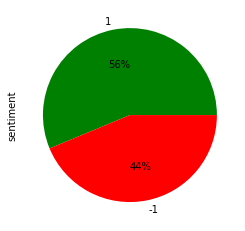

In [47]:
df["sentiment"].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=["green","red"])

In [38]:
words=[i.split() for i in df["features"]]
all_words=list(itertools.chain(*words))
counts=collections.Counter(all_words)
counts.most_common(45)
clean_reviews= pd.DataFrame(counts.most_common(30),columns=['words','count'])
clean_reviews.head()

,words,count
0,product,2754
1,good,2732
2,qualiti,1626
3,nice,1392
4,bad,1310


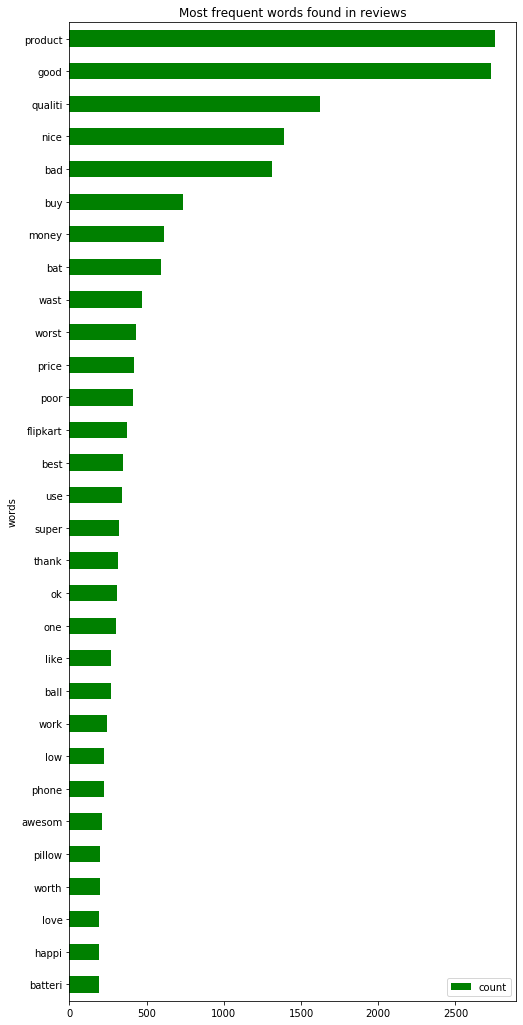

In [49]:
fig,ax=plt.subplots(figsize=(8,18))
clean_reviews.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="green")
ax.set_title("Most frequent words found in reviews")
plt.show()

In [39]:
df.shape

(10676, 6)

In [40]:
index=df.index

In [41]:
index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128,
            12129],
           dtype='int64', length=10676)

In [42]:
df['random_number']=np.random.randn(len(index))

In [43]:
df.head()

,CommentHead,Comment,Rating,length,sentiment,features,random_number
0,Classy product,Very nice product,5,17,1,nice product,0.281144
1,Good choice,Too good,4,8,1,good,0.822188
2,Fabulous!,Good products,5,13,1,good product,-0.118579
3,Hated it!,Very bad products,1,17,-1,bad product,1.159047
4,Super!,Sorry,5,5,1,sorri,-0.655643


In [55]:
df[df['random_number']<=0.8].shape

(8372, 7)

In [56]:
df[df['random_number']>0.8].shape

(2304, 7)

In [44]:
train=df[df['random_number']<=0.8]
test=df[df['random_number']>0.8]

In [45]:
vectorizer=CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix=vectorizer.fit_transform(train['features'])
test_matrix=vectorizer.transform(test['features'])

In [46]:
X_train=train_matrix
X_test=test_matrix
y_train=train['sentiment']
y_test=test['sentiment']

In [48]:
naive=MultinomialNB().fit(X_train, y_train) 
predicted=naive.predict(X_test)

In [50]:
accuracy_score(y_train,naive.predict(X_train))

0.9074470616226505

In [51]:
accuracy_score(y_test,predicted)

0.8806167400881058

In [52]:
naive.predict(vectorizer.transform(["Ok product good only"]))

array([1], dtype=int64)

In [53]:
naive.predict(vectorizer.transform(["horrible product dont buy at all"]))

array([-1], dtype=int64)

In [54]:
naive.predict(vectorizer.transform(["super product"]))

array([1], dtype=int64)

In [55]:
naive.predict(vectorizer.transform(["ok product"]))

array([1], dtype=int64)

In [56]:
naive.predict(vectorizer.transform(["Not at all recommended"]))

array([-1], dtype=int64)

In [57]:
vec_file='vectorizer.pickle'
pickle.dump(vectorizer,open(vec_file, 'wb'))

In [59]:
mod_file = 'classification.model'
pickle.dump(naive, open(mod_file, 'wb'))

In [60]:
loaded_vectorizer=pickle.load(open('vectorizer.pickle', 'rb'))
loaded_model=pickle.load(open('classification.model', 'rb'))
k=loaded_model.predict(loaded_vectorizer.transform(features))

In [61]:
k

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [62]:
loaded_model.predict(loaded_vectorizer.transform(["Ok product good only"]))

array([1], dtype=int64)

In [63]:
loaded_model.predict(loaded_vectorizer.transform(["Not at all recommended"]))

array([-1], dtype=int64)

In [64]:
loaded_model.predict(loaded_vectorizer.transform(["Ok product"]))

array([1], dtype=int64)

In [65]:
loaded_model.predict(loaded_vectorizer.transform(["Horrible"]))

array([-1], dtype=int64)

In [66]:
loaded_model.predict(loaded_vectorizer.transform(["Love that such a wonderful product"]))

array([1], dtype=int64)

In [67]:
type(loaded_vectorizer)

sklearn.feature_extraction.text.CountVectorizer

In [68]:
type(loaded_model)

sklearn.naive_bayes.MultinomialNB

WordCloud

In [103]:
positive=df[df['Rating'] > 3]
negative=df[df['Rating'] < 3]

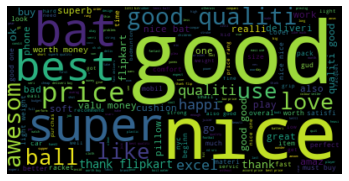

In [108]:
stop_words=set(stopwords.words('english'))
stop_words.update(["href","product"]) 
pos=" ".join(review for review in positive.features)
wordcloud2=WordCloud(stopwords=stop_words).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

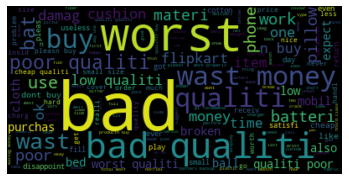

In [114]:
stop_words=set(stopwords.words('english'))
stop_words.update(["br", "href","product","good"]) 
neg = " ".join(review for review in negative.features)
wordcloud3=WordCloud(stopwords=stop_words).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

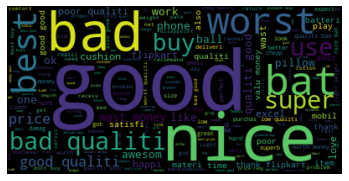

In [113]:
all = " ".join(review for review in df.features)
wordcloud3 = WordCloud(stopwords=stop_words).generate(all)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()